Load the LLM

In [1]:
from langchain_community.llms.mlx_pipeline import MLXPipeline
from langchain_community.chat_models.mlx import ChatMLX
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.globals import set_verbose
from langchain.globals import set_debug

#set_debug(True)
set_verbose(True)

print('Loading model...')
# Load model from huggingface, using the MLX framework to take advantage of Apple Silicon
llm = MLXPipeline.from_model_id(
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-8bit",
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-bf16",
    "mlx-community/Qwen2.5-32B-Instruct-4bit", # Let's try using a larger model, see if that improves results
    #"mlx-community/Llama-3.2-3B-Instruct-8bit",
    pipeline_kwargs={"max_tokens": 2048, "temp": 0.2, "repetition_penalty":1.2},
)

# Setup verbose mode: https://stackoverflow.com/a/77629872/10914628
model = ChatMLX(llm=llm).with_config({'callbacks': [ConsoleCallbackHandler()]})
print('Model loaded.')


Loading model...


/Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 12 files: 100%|██████████| 12/12 [05:17<00:00, 26.43s/it]


Model loaded.


Load the ontology

In [2]:
from generator.utils.serializers import json2llmready

print('Loading ontology...')
with open("story.json", "r") as f:
    ontology = json2llmready(f.read())
print(ontology)

Loading ontology...
[{'ID': 'containsCharacter', 'Type': ['ObjectProperty'], 'Domain': 'Location', 'Range': 'Character', 'InverseOf': 'isAtLocation'}, {'ID': 'performedByCharacter', 'Type': ['ObjectProperty'], 'Domain': 'Action', 'Range': 'Character'}, {'ID': 'Character', 'Type': ['Class'], 'Label': 'Personnage'}, {'ID': 'isFactionMember', 'Type': ['ObjectProperty'], 'Domain': 'Character', 'Range': 'Faction', 'InverseOf': 'hasMember'}, {'ID': 'http://www.florianrieder.com/story.owl', 'Type': ['Ontology']}, {'ID': 'Player', 'Type': ['Class'], 'Label': 'Joueur'}, {'ID': 'Condition', 'Type': ['Class']}, {'ID': 'isControlledByFaction', 'Type': ['ObjectProperty'], 'Domain': 'Location', 'Range': 'Faction', 'InverseOf': 'hasControlOfLocation'}, {'ID': 'hasGoal', 'Type': ['ObjectProperty'], 'Domain': 'Entity', 'Range': 'Goal'}, {'ID': 'Action', 'Type': ['Class'], 'Label': 'Action', 'Comment': 'Une action que peut prendre un personnage'}, {'ID': 'hasRole', 'Type': ['ObjectProperty'], 'Domain': 

Define the setting of the story

In [57]:
setting = "Normandie viking du 9e siècle"

# 1. Generate the outline of the story world

In [58]:
OUTLINE_TEXT_PROMPT = """
You are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.
Write a few paragraphs describing the world of the story following the given narrative setting:

{{ setting }}

Your text should be quite short, concise and descriptive.
Your staff will use this text as the story world bible, they will write the characters, locations and specific events.
You should direct them as precisely as possible to create as coherent and unified world for the player to explore.
Define the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.
Write your output in {{ language }}.
"""

In [59]:
language = "french"

prompt = PromptTemplate(
    input_variables=['setting', 'language'],
    template=OUTLINE_TEXT_PROMPT,
    template_format='jinja2'
)

chain = prompt | model

outline_text = chain.invoke({'setting': setting, 'language': language})

outline_text

Parent run 02c16981-f4d0-4dad-a35d-ab3eeaeec5ad not found for run b24c467c-68d0-4c99-ad86-13f1565db73c. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nYou are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.\nWrite a few paragraphs describing the world of the story following the given narrative setting:\n\nNormandie viking du 9e siècle\n\nYour text should be quite short, concise and descriptive.\nYour staff will use this text as the story world bible, they will write the characters, locations and specific events.\nYou should direct them as precisely as possible to create as coherent and unified world for the player to explore.\nDefine the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.\nWrite your output in french."
  ]
}
[llm/end] [llm:ChatMLX] [102.43s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Dans le monde des Normands du IXème siècle, la société est dominée par les guerriers et naviga

AIMessage(content="Dans le monde des Normands du IXème siècle, la société est dominée par les guerriers et navigateurs intrépides qui ont établi leur puissance sur les vastes mers d'Europe. Les terres sont parsemées de villages fortifiés entourés de haies épines pour protéger contre les raids ennemis. La culture se caractérise par une foi profonde dans l'honneur martial et un respect inné pour Odin, Thor et Freya.\n\nLe joueur incarne un jeune Viking ambitieux cherchant à prouver sa valeur en accomplissant des quêtes héroïques. Son objectif principal consiste à rassembler suffisamment de richesses et de renommée pour fonder son propre clan ou rejoindre celui d'un chef réputé. Le conflit central tournera autour des rivalités entre clans locaux et des attaques constantes des forces extérieures qui menacent la sécurité et la prospérité des communautés normandes. \n\nLes personnages seront imprégnés de valeurs comme la bravoure, mais aussi confrontés aux réalités cruelles de cette ère où l

In [30]:
print(outline_text.content)

Bienvenue dans le monde des Vikings de Normandie au IXème siècle. Ce royaume est un mélange d'histoire et de légendes où la mer sert à la fois comme voie vers l'inconnu et comme frontière protectrice contre les envahisseurs. Les terres sont fertiles mais difficiles, couvertes parfois de vastes forêts aux mystères innombrables.

Le joueur incarnera un jeune guerrier ou une jeune guerrière Viking qui aspire à gagner honneur et richesse en explorant ces contrées lointaines et menacées. Le personnage doit naviguer entre alliances tribales instables et conflits internationaux naissants pour prouver sa valeur face aux autres clans et protéger son peuple des dangers extérieurs et intérieurs.

La quête principale consiste à rassembler les artefacts sacrés dispersés sur plusieurs îles afin de renforcer leur clan avant que ne survienne une menace commune plus grande encore : une invasion présumée d'une puissance étrangère redoutable. Chaque décision prise aura des répercussions immenses sur le d

# 2. Generate locations

In [63]:
LOCATIONS_GENERATION_PROMPT = """
You are the master world writer for an interactive fiction.
On the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.
Define at least 4 to 5 main locations, as well as intermediate locations if pertinent.
Your staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !
You must take utmost care in creating a logical topology with no islands and coherent connections.
Always refer to other locations using their "name" property in the links ! You should define all locations mentioned in the links.

Output your work in the following JSON format:
```json
    "Locations": [
        {
            "name": "Gravepine",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Chateau"]
        },
        {
            "name": "Chateau",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Gravepine", "Nom d'un autre lieu"]
        },
        ...
    ],
```

Narrative context:
{{ context }}

Your output JSON values should always be in {{ language }}
"""

In [66]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

from generator.parsers import OutlineParser

prompt = PromptTemplate(
    input_variables=['setting'],
    template=LOCATIONS_GENERATION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser() # OutlineParser

chain = prompt | model | parser

locations_output = chain.invoke({'context': outline_text.content, 'language': language})


Parent run 721b4a81-a65c-441f-b014-d8b69c2e2295 not found for run 00c33967-236f-474e-b03e-5e73c91a66e2. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nYou are the master world writer for an interactive fiction.\nOn the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.\nDefine at least 4 to 5 main locations, as well as intermediate locations if pertinent.\nYour staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !\nYou must take utmost care in creating a logical topology with no islands and coherent connections.\nAlways refer to other locations using their \"name\" property in the links ! You should define all locations mentioned in the links.\n\nOutput your work in the following JSON format:\n```json\n    \"Locations\": [\n        {\n            \"name\": \"Gravepine\",\n            \"importance\": \"Either 'major' or 'minor', this annotation will influence how your staff will detail the\"\n           

In [70]:
location_outlines = locations_output['Locations']
location_outlines

[{'name': 'Village Fortifié de Gravepine',
  'importance': 'major',
  'description': "Ce village fortifié est situé près d'une baie stratégique, offrant un abri sûr pour les navires vikings lorsqu'ils rentrent après leurs expéditions lointaines. Entouré de haies d'épines et doté d'une muraille solide, il sert également de centre administratif local sous la protection d’un jarl respecté.",
  'links': ['Forêt Sombre', 'Port Marchand', 'Colline Sacrée']},
 {'name': 'Forêt Sombre',
  'importance': 'minor',
  'description': 'Une étendue sombre et mystérieuse peuplée de créatures légendaires selon les histoires locales. Elle offre refuge et ressources naturelles essentielles pour le village voisin, mais reste dangereuse sans guide compétent.',
  'links': ['Village Fortifié de Gravepine', 'Grottes Anciennes']},
 {'name': 'Port Marchand',
  'importance': 'major',
  'description': "Un port animé où les commerçants viennent négocier des marchandises précieuses venues des quatre coins de l’Europe

In [91]:
from dataclasses import abc, dataclass, field
from typing import Optional, List

@dataclass
class LocationData:
    name: str
    description: str
    stance: Optional[str] = None
    relationships: Optional[List[str]] = field(default_factory=list)
    characters: Optional[List[str]] = field(default_factory=list)
    items: Optional[List[dict]] = field(default_factory=list)
    
    def to_llm_string(self) -> str:
        string = f'"{self.name}": {self.description}\n\t'
        if self.relationships:
            string += f'"{self.name}" est connecté à {' et '.join(f'"{rel}"'for rel in self.relationships)}\n\t'
        if self.stance:
            string += f'"{self.name}" est {self.stance} envers le joueur'

        return string
    
print(LocationData(name='Gravepine', description='blabla', relationships=['chateau', 'foret']).to_llm_string())

"Gravepine": blabla
	"Gravepine" est connecté à "chateau" et "foret"
	


In [92]:
# Encoder les lieux sous forme d'objets
locations = []
for loc in location_outlines:
    location = LocationData(name=loc['name'], description=loc['description'], relationships=loc['links'])
    print(location)
    locations.append(location)

LocationData(name='Village Fortifié de Gravepine', description="Ce village fortifié est situé près d'une baie stratégique, offrant un abri sûr pour les navires vikings lorsqu'ils rentrent après leurs expéditions lointaines. Entouré de haies d'épines et doté d'une muraille solide, il sert également de centre administratif local sous la protection d’un jarl respecté.", stance=None, relationships=['Forêt Sombre', 'Port Marchand', 'Colline Sacrée'], characters=[], items=[])
LocationData(name='Forêt Sombre', description='Une étendue sombre et mystérieuse peuplée de créatures légendaires selon les histoires locales. Elle offre refuge et ressources naturelles essentielles pour le village voisin, mais reste dangereuse sans guide compétent.', stance=None, relationships=['Village Fortifié de Gravepine', 'Grottes Anciennes'], characters=[], items=[])
LocationData(name='Port Marchand', description="Un port animé où les commerçants viennent négocier des marchandises précieuses venues des quatre coi

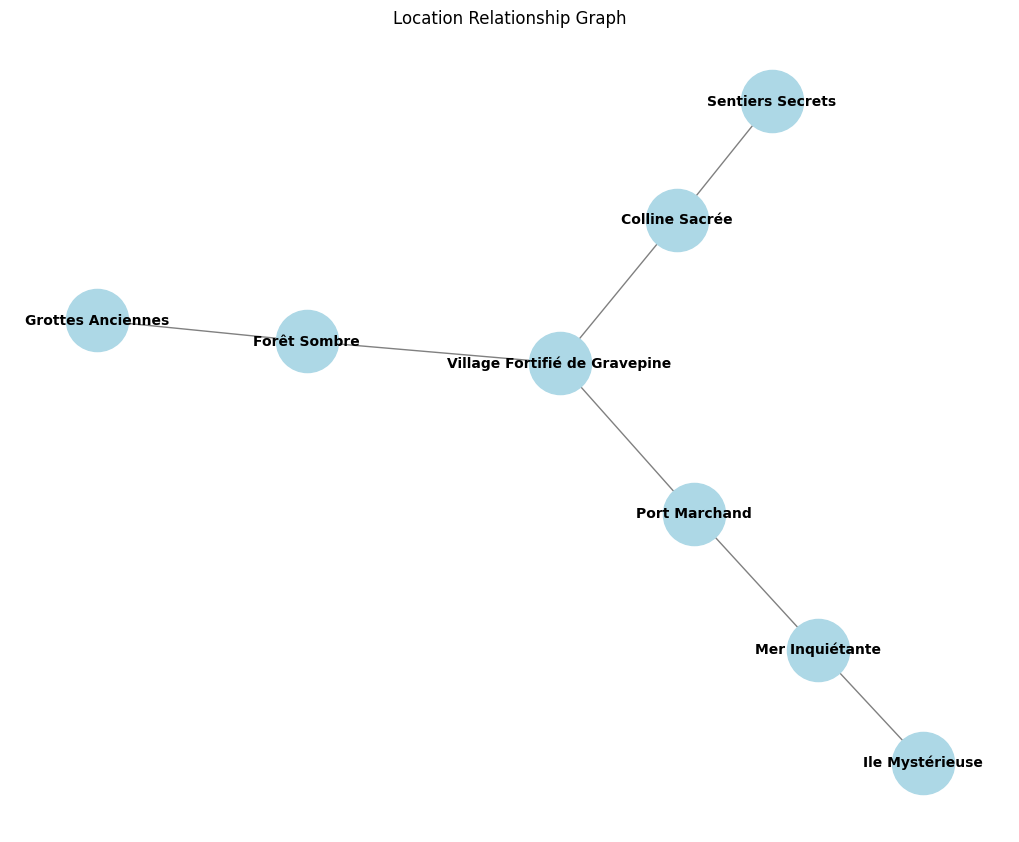

In [93]:
import networkx as nx
import matplotlib.pyplot as plt

def display_location_relationships(locations: List[LocationData]):
    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for location in locations:
        G.add_node(location.name)  # Add each location as a node
        for related_location in location.relationships:
            # Create edges for relationships
            G.add_edge(location.name, related_location)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Positioning of the graph

    # Draw nodes, edges, and labels
    nx.draw(G, pos,
            with_labels=True,
            node_color='lightblue',
            node_size=2000,
            font_size=10,
            font_weight='bold',
            edge_color='gray')
    plt.title('Location Relationship Graph')
    plt.show()

display_location_relationships(locations)

Structure works, it's a hub structure with linear branches. Good enough !
Extra points for the water structure

In [87]:
STORY_OUTLINE_PROMPT = """
# Instructions pour la génération
Vous êtes le scénariste de l'histoire pour une aventure textuelle générative.
Sur la base du contexte narratif et des lieux qui composent le monde ci-dessous, générez les grandes lignes d'une histoire possible en tenant créant les éléments suivants :

    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.
    Personnages: Etablir une liste d'au moins **3 à 5** personnages principaux de l'histoire, sans rentrer dans trop de détails mais en évoquant leur fonction narrative et leurs relations (entre eux et avec le joueur). Veille à établir au moins un antagoniste principal.
    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif qui motive l'action.
    Événements : Décrire au moins 1 à 3 événements clés qui alimentent l'histoire et doivent être déclenchés par l'action du joueur.
    Objets : Générer uniquement les éléments essentiels nécessaires pour compléter l'histoire (objets de quête) si c'est mentionné dans le contexte narratif, en incluant : Un nom et une description de chaque objet, avec sa fonction dans le récit. Indiquer le lieu où se trouve chaque objet, en s'assurant qu'il s'intègre logiquement dans le monde.
    Commentaires : Inclure tout commentaire supplémentaire qui pourrait guider la génération de détails supplémentaires ou éclaircir des éléments importants de l'histoire.

# Format de sortie
D'abord, raisonner sur le contexte narratif donné et son importance pour la cohérence du monde et de l'histoire, l'intrigue principale (qui doit être de nature ouverte), et les relations des personnages.
Fournir les éléments dans un fichier json structuré selon le format suivant:
{
    "Player": {
        "name": "Donner le nom du personnage qu'incarne le joueur",
        "description": "Description en quelques phrases du personnage qu'incarne le joueur",
        "location": "Nom du lieu de départ de l'histoire"
    },
    "Characters": [
        {
            "name": "Nom propre du personnage 1",
            "description": "description en une phrase du personnage, incorporant son rôle et sa fonction dans l'histoire, et sa relation aux autres personnages.",
            "location": "Nom du lieu ou se trouve le personnage"
        },
        ...
    ],
    "Goal": {
        "description": "description du problème ou de l'enjeu qui motive le joueur. La résolution du jeu doit rester ouverte"
        "requiresItem": "(FACULTATIF) S'il un objet qui est le centre de l'histoire et doit être récupéré pour gagner, l'indiquer ici. Sinon, omettre ce champs."
    },
    "Events": [
        {
            "name": "Evènement 1",
            "description": "description de l'évènement",
            "condition": "description de la condition qui déclenche l'évènement (devrait être déclenché par l'action du joueur !)",
            "consequences": ["Une ou plusieurs conséquences à l'évènement", "deuxième conséquence possible"]
        },
        ...
    ],
    "Items": [
        {
            "name": "Nom de l'objet",
            "description": "description courte de l'objet et de sa fonction dans le récit",
            "location": "(OBLIGATOIRE) Nom du lieu qui contient l'objet"
        },
        ...
    ],
    "Comments": [
        "Tout commentaire que tu voudrais ajouter pour guider la génération de détails supplémentaires et pendant le jeu. Sois précis plus que général: donne des commentaires qui peuvent être exploités. Des éléments importants de l'histoire"
    ]
}


# Lieux du monde
{%- for location in locations %}
{{ location.to_llm_string() }}
{%- endfor %}

# Contexte narratif
{{ setting }}

Rappel: Ne répète pas les lieux du monde. Ton objectif est de développer une histoire qui fonctionne dans ce monde. N'ajoute que des éléments nouveaux dans le JSON. Fournis seulement les informations sur le joueur, son objectif, les personnages principaux, les évènements principaux, les éventuels objets principaux.

# Résultat
"""

In [94]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

from generator.parsers import OutlineParser

prompt = PromptTemplate(
    template=STORY_OUTLINE_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser() # OutlineParser

chain = prompt | model | parser

story_outline = chain.invoke({'setting': outline_text.content, 'locations': locations})



Parent run 049a15aa-f7c7-43f2-b30a-00972c320823 not found for run aef0872e-5b96-44d1-bfb4-787083ced588. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \n# Instructions pour la génération\nVous êtes le scénariste de l'histoire pour une aventure textuelle générative.\nSur la base du contexte narratif et des lieux qui composent le monde ci-dessous, générez les grandes lignes d'une histoire possible en tenant créant les éléments suivants :\n\n    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.\n    Personnages: Etablir une liste d'au moins **3 à 5** personnages principaux de l'histoire, sans rentrer dans trop de détails mais en évoquant leur fonction narrative et leurs relations (entre eux et avec le joueur). Veille à établir au moins un antagoniste principal.\n    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif

In [95]:
story_outline

{'Player': {'name': 'Erik Stormwind',
  'description': 'Un jeune Viking ambitieux originaire du Village Fortifié de Gravepine, désireux de faire ses preuves et acquérir gloire et richesse afin de fonder son propre clan.',
  'location': 'Village Fortifié de Gravepine'},
 'Characters': [{'name': 'Jarl Bjorn Ironheart',
   'description': 'Jarls protecteur du Village Fortifié de Gravepine; figure paternelle pour Erik, mais aussi source potentielle de conflit si Erik cherche à surpasser son autorité.',
   'location': 'Village Fortifié de Gravepine'},
  {'name': 'Sigrun the Seeress',
   'description': 'Oracle vivant dans Forêt Sombre, possède des visions prophétiques qui peuvent aider Erik dans sa quête, mais demande toujours quelque chose en retour.',
   'location': 'Forêt Sombre'},
  {'name': 'Thorgils Blackeye',
   'description': 'Antagoniste - Capitaine pirate connu pour harceler les navires commerciaux traversant Mer Inquiétante ; menace directe pour la sécurité économique locale.',
   

In [168]:
@dataclass
class CharacterData:
    name: str
    description: str
    location: str
    relationships: Optional[list] = field(default_factory=list)
    importance: Optional[str] = 'minor'


In [119]:
# Convert JSON to CharacterData objects
characters = list()

for character in story_outline['Characters']:
    character_obj = CharacterData(
        name = character.get('name'),
        description = character.get('description'),
        location = character.get('location'),
        importance = 'major'
    )
    
    characters.append(character_obj)
    print(character_obj)

CharacterData(name='Jarl Bjorn Ironheart', description='Jarls protecteur du Village Fortifié de Gravepine; figure paternelle pour Erik, mais aussi source potentielle de conflit si Erik cherche à surpasser son autorité.', location='Village Fortifié de Gravepine', relationships=[])
CharacterData(name='Sigrun the Seeress', description='Oracle vivant dans Forêt Sombre, possède des visions prophétiques qui peuvent aider Erik dans sa quête, mais demande toujours quelque chose en retour.', location='Forêt Sombre', relationships=[])
CharacterData(name='Thorgils Blackeye', description='Antagoniste - Capitaine pirate connu pour harceler les navires commerciaux traversant Mer Inquiétante ; menace directe pour la sécurité économique locale.', location='Mer Inquiétante', relationships=[])


In [169]:
@dataclass
class PlayerData:
    name: str
    description: str
    goal: str
    location: str

In [110]:
player = PlayerData(
    name = story_outline['Player']['name'],
    description = story_outline['Player']['description'],
    goal = story_outline['Goal']['description'],
    location = story_outline['Player']['location'],
)
player

PlayerData(name='Erik Stormwind', description='Un jeune Viking ambitieux originaire du Village Fortifié de Gravepine, désireux de faire ses preuves et acquérir gloire et richesse afin de fonder son propre clan.', goal="Collecter des artefacts anciens et des trésors pour augmenter sa notoriété et rassembler les moyens financiers nécessaires à la fondation d'un nouveau clan.", location='Village Fortifié de Gravepine')

In [120]:
CHARACTER_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the character.

Character Name: {{character.name}}
Description: {{character.description}}
Starting location: {{character.location}}

Other main characters of the story:
{%- for char in other_characters %}
    "{{ char.name }}": {{ char.description }} (is located at {{char.location}})
{%- endfor %}

The player:
    "{{ player.name }}": {{ player.description }} (is located at {{player.location}})
    The player has the goal: {{player.goal}}

Please include:
- A significant backstory element that explain their current situation. Improving the character's current description
- One or two relationships that the character has with other main characters or the player.

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.
Output your response in the following JSON format:

{
    "description": "The updated, expanded description of the character, defining their goals, motivations, and conflicts",
    "relationships": [
        {
            "type": "either 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language ",
            "target": "Name of the character which has that relationship with {{character.name}}"
        },
        ...
    ]
}

Write all the JSON value strings in {{language}}, except relationship types.
"""

In [113]:

prompt = PromptTemplate(
    template=CHARACTER_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

expanded_main_characters = list()

for character in characters:

    # Get the list of other main characters
    other_characters = list()
    for other_character in characters:
        if other_character.name == character.name:
            continue
        other_characters.append(other_character)
    
    print(character)

    res = chain.invoke({"setting": outline_text.content,
                        "character": character,
                        "player": player,
                        "other_characters": other_characters,
                        "language": language})

    character.description = res['description']
    character.relationships = res['relationships']
    expanded_main_characters.append(character)
    print('----*----')
    print(res)
    print('----*----')

Parent run af6e5255-e9b0-4345-8564-99906427d9d4 not found for run 2e354c99-06fe-4872-8cc6-fcf733b34615. Treating as a root run.


CharacterData(name='Jarl Bjorn Ironheart', description='Jarls protecteur du Village Fortifié de Gravepine; figure paternelle pour Erik, mais aussi source potentielle de conflit si Erik cherche à surpasser son autorité.', relationships=[])
[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nUsing the following details, generate a JSON output with additional information about the character.\n\nCharacter Name: Jarl Bjorn Ironheart\nDescription: Jarls protecteur du Village Fortifié de Gravepine; figure paternelle pour Erik, mais aussi source potentielle de conflit si Erik cherche à surpasser son autorité.\nStarting location: \n\nOther main characters of the story:\n    \"Sigrun the Seeress\": Oracle vivant dans Forêt Sombre, possède des visions prophétiques qui peuvent aider Erik dans sa quête, mais demande toujours quelque chose en retour. (is located at )\n    \"Thorgils Blackeye\": Antagoniste - Capitaine pirate connu pour harceler les navires commercia

Parent run 624cbf59-559b-4c57-acdb-ca1e32831818 not found for run 3732c161-fcf5-4bd4-a854-801fe3fb0c22. Treating as a root run.


[llm/end] [llm:ChatMLX] [106.72s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "{\n  \"character_name\": \"Jarl Bjorn Ironheart\",\n  \"description\": \"Protector du Village Fortifié de Gravepine depuis plusieurs décennies, Jarl Bjorn Ironheart est une figure respectée et aimée par tous. Son histoire personnelle l'a façonné : il était autrefois un guerrier solitaire avant que le village ne soit attaqué par Thorgils Blackeye lorsqu'il n'était encore qu'une simple communauté sans défense. Depuis cette époque sombre, Bjorn s'est engagé à protéger ce lieu et ceux qui y habitent avec toute la force dont il dispose. Cependant, malgré son dévouement indéniable, Bjorn sent parfois que Erik, son fils adoptif, aspire à prendre sa place comme leader du village.\",\n  \"starting_location\": \"Village Fortifié de Gravepine\",\n  \"goals_and_motivations\": [\"Maintenir la paix et la protection du Village Fortifié\", \"Guider Erik vers maturité tout en préservant le

Parent run 387acdaa-8ffe-414d-8c8e-af99377385bb not found for run 281a9b09-cccc-4cdf-a38c-c1adea128c08. Treating as a root run.


[llm/end] [llm:ChatMLX] [42.58s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "{\n  \"character_name\": \"Sigrun the Seeress\",\n  \"description\": \"Oracle vivant mystérieusement au cœur de la Forêt Sombre, Sigrun the Seeress possède des visions prophétiques capables de révéler aux voyageurs intrépides leur destin proche ou lointain. Nourrie par des années passées seule face aux secrets de la nature environnante, elle offre ses prédictions précieuses contre des offrandes ou des services rendus. Elle joue souvent le rôle d’un guide spirituel imprévisible pour ceux cherchant des réponses sur leurs chemins de vie. Sa relation complexe avec Erik, qui cherche constamment à comprendre davantage de son futur incertain, ajoute une dimension intrigante à leur interaction.\",\n  \"starting_location\": \"Forêt Sombre\",\n  \"relationships\": [\n      {\"type\": \"friend\", \"target\": \"Erik Stormwind\"},\n      {\"type\": \"enemy\", \"target\": \"Thorgils Blac

In [114]:
characters

[CharacterData(name='Jarl Bjorn Ironheart', description="Protector du Village Fortifié de Gravepine depuis plusieurs décennies, Jarl Bjorn Ironheart est une figure respectée et aimée par tous. Son histoire personnelle l'a façonné : il était autrefois un guerrier solitaire avant que le village ne soit attaqué par Thorgils Blackeye lorsqu'il n'était encore qu'une simple communauté sans défense. Depuis cette époque sombre, Bjorn s'est engagé à protéger ce lieu et ceux qui y habitent avec toute la force dont il dispose. Cependant, malgré son dévouement indéniable, Bjorn sent parfois que Erik, son fils adoptif, aspire à prendre sa place comme leader du village.", relationships=[{'type': 'father', 'target': 'Erik Stormwind'}, {'type': 'protector', 'target': 'Le Village Fortifié de Gravepine'}]),
 CharacterData(name='Sigrun the Seeress', description='Oracle vivant mystérieusement au cœur de la Forêt Sombre, Sigrun the Seeress possède des visions prophétiques capables de révéler aux voyageurs 

In [129]:
@dataclass
class ItemData:
    name: str
    description: str
    location: str
    quantity: Optional[int] = 1
    importance: Optional[str] = 'minor'

In [130]:
items = list()
for item in story_outline.get('Items'):
    item_obj = ItemData(
        name = item.get('name'),
        description = item.get('description'),
        location = item.get('location'),
        quantity = int(item.get('quantity', 1)),
        importance = 'major'
    )
    items.append(item_obj)
items

[ItemData(name='Amulette Runique', description='Objet magique trouvé dans Colline Sacrée qui augmente la force physique et mentale de son détenteur.', location='Colline Sacrée', quantity=1),
 ItemData(name='Carte Antique', description='Indication vers un trésor perdu dans les Grottes Anciennes.', location='Port Marchand', quantity=1)]

In [154]:
all_item_names = list()
for item in items:
    all_item_names.append(item.name)

all_character_names = list()

all_character_names.append(player.name)

for character in characters:
    all_character_names.append(character.name)
    

print(all_item_names)
print(all_character_names)

['Amulette Runique', 'Carte Antique']
['Erik Stormwind', 'Jarl Bjorn Ironheart', 'Sigrun the Seeress', 'Thorgils Blackeye']


In [158]:
LOCATION_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the location.

Setting of the story: {{setting}}

Location Name: {{location.name}}
Description: {{location.description}}
Neighboring locations:
{%- for nearby_location in nearby_locations %}
    {{ nearby_location.to_llm_string() }}
{%- endfor %}

{%- if characters %}
Main characters in "{{location.name}}":
{%- if player %}
    - "{{player.name}}" (Player): {{player.description}}
        The player has the goal: {{player.goal}}
{%- endif %}
{%- for character in characters %}
    - "{{ character.name }}": {{ character.description }}
{%- endfor %}
{%- endif %}

{%- if items %}
The location contains the quest item(s):
{%- for item in items %}
    - "{{ item.name }}": {{ item.description }}
{%- endfor %}
{%- endif %}

please DO NOT include this information in your output

Please include:
- Up to two secondary characters that would be relevant to this location. Keep in mind that secondary caracters should have a use to the player, that is either to give the player some important information (define specifically the information), some items, trade or offer a challenge, or other if it is relevant to the scene and the story.
- Up to two items that could be found or are important in this location. Items should always have a clear use at least in the scene.

Do not call any character these names: {{banned_character_names}}
Do not call any item these names: {{banned_item_names}}
{%- if used_roles %}
Already used secondary character roles (Try not to repeat them too much. Only if it really makes sense): {{used_roles}}
{%- endif %}

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.

Make sure to output the list of characters as JSON, following this exact model:

{
    "Description": "A longer, more detailed description of the location and perhaps its different parts and their function in the story"
    "Characters": [
        {
            "name": "The name of the character",
            "description": "A concise description of the character and their function in the scene.",
            "role": "One or two words describing this character's function"
        },
        ...
    ],
    "Items": [
        {
            "name": "The name of the item",
            "description": "A concise description of the item and its function.",
            "quantity": 1,
        },
        ...
    ]
}

Generate all output in {{ language }}
"""

In [159]:

prompt = PromptTemplate(
    template=LOCATION_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser


used_roles = list()
banned_character_names = all_character_names
banned_item_names = all_item_names

expanded_locations = list()
for location in locations:
    # Characters
    characters_in_location = list()
    for character in characters:
        if character.location == location.name:
            characters_in_location.append(character)
    
    # Player
    player_in_location = None
    if player.location == location.name:
        player_in_location = player
    
    # Items
    items_in_location = list()
    for item in items:
        if item.location == location.name:
            items_in_location.append(item)
    
    nearby_location = list()
    for other_location in locations:
        if other_location.name in location.relationships:
            nearby_location.append(other_location)

    res = chain.invoke({"setting": outline_text.content,
                        "location": location,
                        "nearby_locations": nearby_location,
                        "characters": characters_in_location,
                        "items": items_in_location,
                        "player": player_in_location,
                        "banned_item_names": all_item_names,
                        "banned_character_names": all_character_names,
                        "used_roles": used_roles,
                        "language": language})
    
    for item in res['Items']:
        all_item_names.append(item.get('name'))
    
    for character in res.get('Characters'):
        all_character_names.append(character.get('name'))
        used_roles.append(character.get('role'))

    expanded_locations.append(res)
    print('----*----')
    print(res)
    print('----*----')


Parent run ec6e047b-bdde-4925-af1e-9950ab4e73b8 not found for run 86585cf2-3e44-40a6-8e04-65b27a86afad. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nUsing the following details, generate a JSON output with additional information about the location.\n\nSetting of the story: Dans le monde des Normands du IXème siècle, la société est dominée par les guerriers et navigateurs intrépides qui ont établi leur puissance sur les vastes mers d'Europe. Les terres sont parsemées de villages fortifiés entourés de haies épines pour protéger contre les raids ennemis. La culture se caractérise par une foi profonde dans l'honneur martial et un respect inné pour Odin, Thor et Freya.\n\nLe joueur incarne un jeune Viking ambitieux cherchant à prouver sa valeur en accomplissant des quêtes héroïques. Son objectif principal consiste à rassembler suffisamment de richesses et de renommée pour fonder son propre clan ou rejoindre celui d'un chef réputé. Le conflit central tournera autour des rivalités entre clans locaux et des attaques constantes des forces extérieures qui m

Parent run 6c03db54-8bb2-46b8-8cbb-78bfa3eb9e99 not found for run b2b95c4f-ee50-4846-b286-4bed3534a525. Treating as a root run.


[llm/end] [llm:ChatMLX] [91.31s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Ce village fortifié est situé près d'une baie stratégique, offrant un abri sûr pour les navires vikings lorsqu'ils rentrent après leurs expéditions lointaines. Entouré de haies d’épines et doté d’une muraille solide, il sert également de centre administratif local sous la protection d’un jarl respecté. Grâce à sa position géographique avantageuse, le village jouit d’une certaine autonomie tout en restant vulnérable aux attaques externes.\",\n    \"Characters\": [\n        {\n            \"name\": \"Hilda la Forgeronne\",\n            \"description\": \"Une femme robuste connue pour sa forge exceptionnelle située juste à l'intérieur des remparts. Hilda peut fournir des armes et des équipements de haute qualité aux aventuriers courageux qui lui apportent certains matériaux rares trouvés dans les environs.\",\n            \"role\": \"Fourniss

Parent run bedd40bd-bde1-4d9f-99d1-2d5ce3695177 not found for run b9260415-65d7-466e-b712-adfc258b75f4. Treating as a root run.


[llm/end] [llm:ChatMLX] [70.39s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Une étendue sombre et mystérieuse peuplée de créatures légendaires selon les histoires locales. Elle offre refuge et ressources naturelles essentielles pour le Village Fortifié de Gravepine, mais reste dangereuse sans guide compétent.\",\n    \"Characters\": [\n        {\n            \"name\": \"Orvar le Chasseur\",\n            \"description\": \"Un chasseur aguerri connaissant bien les dangers secrets de la forêt. Il peut fournir des informations cruciales sur les chemins sûrs et les points d'eau potable.\",\n            \"role\": \"Chasseur\"\n        },\n        {\n            \"name\": \"Liaison Rune\",\n            \"description\": \"Une femme douce et discrète qui collecte des herbes médicinales rares dans la forêt. Elle pourrait donner quelques potions curatives si elle apprend que vous avez aidé quelqu'un dans besoin.\",\n        

Parent run 838f67cd-8cb5-4d2c-94ba-7db7feb750e0 not found for run d8835470-522d-42d0-a389-1bc18143f066. Treating as a root run.


[llm/end] [llm:ChatMLX] [85.03s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Un port animé où les commerçants viennent négocier des marchandises précieuses venues des quatre coins de l’Europe. C'est ici que beaucoup de riches transactions commerciales prennent place, faisant de ce lieu un carrefour vital pour toute personne souhaitant amasser fortune et prestige. Situé près de deux autres lieux importants : Village Fortifié de Gravepine et Mer Inquiétante, ce port offre non seulement des opportunités commerciales, mais aussi des informations cruciales sur les mouvements des bateaux et les dernières rumeurs concernant les voyages et les découvertes.\",\n    \"Characters\": [\n        {\n            \"name\": \"Gudrun la Négociatrice\",\n            \"description\": \"Une femme rusée et habile dans les affaires, capable de tirer profit même des situations les plus difficiles. Elle peut fournir des informations sur le

Parent run 8a75c813-4225-4d7b-baec-2a13e891c28e not found for run cc5fa071-db62-4d5f-ac87-64c3e6c47647. Treating as a root run.


[llm/end] [llm:ChatMLX] [78.68s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"La Colline Sacrée est un lieu empreint de mysticisme et de spiritualité, dédié aux divins dieux nordiques : Odin, Thor et Freya. C'est ici que les Vikings célèbrent des rites importants afin d’obtenir la bienveillance divine pour leurs futures aventures maritimes. Gravées dans la roche, on peut trouver des runes anciennes porteurs de savoir ancestral, ajoutant encore plus de prestige à ce sanctuaire.\",\n    \"Characters\": [\n        {\n            \"name\": \"Harald le Sage\",\n            \"description\": \"Un vieillard barbu habillé simplement, Harald possède une connaissance approfondie des légendes et rituels associés aux dieux nordiques. Il offre des conseils spirituels et explique comment interpréter certaines runes trouvées sur place.\",\n            \"role\": \"Conseiller Spirituel\"\n        },\n        {\n            \"name\": 

Parent run 70e15d06-583d-47b7-aab3-019e2fd3cb6e not found for run e370f3b5-2326-4d71-a42f-5f21a40af584. Treating as a root run.


[llm/end] [llm:ChatMLX] [70.84s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Système souterrain ancien rempli de trésors perdus depuis longtemps et potentiellement habité par des esprits malveillants. Ces grottes représentent un grand risque mais aussi une grande opportunité pour ceux ayant assez de courage et de chance pour explorer ses recoins obscurs.\",\n    \"Characters\": [\n        {\n            \"name\": \"Oldrún la Voyante\",\n            \"description\": \"Une femme âgée dotée de pouvoirs divinatoires qui peut aider le joueur à naviguer à travers les dangers des Grottes Anciennes grâce à des visions prophétiques.\",\n            \"role\": \"Prophète\"\n        },\n        {\n            \"name\": \"Grímarr le Mineur\",\n            \"description\": \"Un mineur expérimenté qui possède des connaissances précieuses sur les passages secrets et les pièges des cavernes. Il peut fournir des informations crucial

In [177]:
expanded_locations[0]

{'Description': "Ce village fortifié est situé près d'une baie stratégique, offrant un abri sûr pour les navires vikings lorsqu'ils rentrent après leurs expéditions lointaines. Entouré de haies d’épines et doté d’une muraille solide, il sert également de centre administratif local sous la protection d’un jarl respecté. Grâce à sa position géographique avantageuse, le village jouit d’une certaine autonomie tout en restant vulnérable aux attaques externes.",
 'Characters': [{'name': 'Hilda la Forgeronne',
   'description': "Une femme robuste connue pour sa forge exceptionnelle située juste à l'intérieur des remparts. Hilda peut fournir des armes et des équipements de haute qualité aux aventuriers courageux qui lui apportent certains matériaux rares trouvés dans les environs.",
   'role': 'Fournisseur'},
  {'name': 'Oswin le Récitant',
   'description': 'Un vieillard sage qui passe ses journées assis devant la grande salle commune, racontant des histoires ancienne et donnant des indices i

In [175]:
for character in characters:
    character.importance = 'major'

for location, expanded_location in zip(locations, expanded_locations):
    
    # Here we replace, but we could have a long_description and a short_description
    location.description = expanded_location.get('Description')
    
    for character in expanded_location.get('Characters'):
        character_obj = CharacterData(
            name = character.get('name'),
            description = character.get('description'),
            location = location.name,
            importance = 'minor'
        )
        
        characters.append(character_obj)
    
    for item in expanded_location.get('Items'):
        item_obj = ItemData(
            name = item.get('name'),
            description = item.get('description'),
            location = location.name,
            quantity = int(item.get('quantity', 1))
        )
        
        items.append(item_obj)
    

    

In [180]:
print(locations)
print(characters)
print(items)

[LocationData(name='Village Fortifié de Gravepine', description="Ce village fortifié est situé près d'une baie stratégique, offrant un abri sûr pour les navires vikings lorsqu'ils rentrent après leurs expéditions lointaines. Entouré de haies d’épines et doté d’une muraille solide, il sert également de centre administratif local sous la protection d’un jarl respecté. Grâce à sa position géographique avantageuse, le village jouit d’une certaine autonomie tout en restant vulnérable aux attaques externes.", stance=None, relationships=['Forêt Sombre', 'Port Marchand', 'Colline Sacrée'], characters=[], items=[]), LocationData(name='Forêt Sombre', description='Une étendue sombre et mystérieuse peuplée de créatures légendaires selon les histoires locales. Elle offre refuge et ressources naturelles essentielles pour le Village Fortifié de Gravepine, mais reste dangereuse sans guide compétent.', stance=None, relationships=['Village Fortifié de Gravepine', 'Grottes Anciennes'], characters=[], ite

# Convert informations to knowledge graph

In [183]:
from owlready2 import *

from ontology_manager import list_onto, add_location

# Create an ontology
onto = get_ontology("http://www.florianrieder.com/story.owl")

with onto:
    # Class Definitions
    class Entity(Thing):
        label = "Entité"

    class Character(Entity):
        """Represents a character in the story, such as a player or NPC."""
        label = "Personnage"

    class Player(Character):
        label = "Joueur"

    class Location(Thing):
        label = "Lieu"

    class Item(Entity):
        label = "Objet"

    class Action(Thing):
        """Represents an action that can be performed by a character."""
        label = "Action"
        comment = "Une action que peut prendre un personnage"

    class Event(Thing):
        label = "Evènement"

    class Consequence(Thing):
        label = "Conséquence"

    class Emotion(Thing):
        label = "Emotion"

    class Goal(Thing):
        label = "Objectif"

    class PersonalityTrait(Thing):
        label = "Trait de personnalité"

    class Role(Thing):
        label = "Role"

    class Condition(Thing):
        label = "Condition"

    class Information(Thing):
        label = "Information"

    # Object Properties

    class containsCharacter(Location >> Character):
        """Indicates that a location contain a characters."""
        label = "contient le personnage"

    class containsItem(Location >> Item):
        """Indicates that a location contains an item"""
        label = "contient l'objet"

    class hasActionPlan(Character >> Action):
        """Indicates that a character has a plan."""
        label = "planifie"

    class hasConsequences(Event >> Consequence):
        """Indicates that an action has a consequence"""
        label = "a comme conséquence"

    class hasEffectOn(Action >> Entity):
        """Indicates that a an action has an effect on an entity"""
        label = "a un effet sur"

    class hasEmotionalState(Character >> Emotion):
        """Indicates that a character has an emotional state"""
        label = "a l'état emotionnel"

    class hasGoal(Entity >> Goal):
        """Indicates that a character has a goal"""
        label = "a comme objectif"

    class hasPersonalityTrait(Character >> PersonalityTrait):
        """Indicates that a character has a personality trait"""
        label = "a le trait de personnalité"

    # Character relationships
    class hasFriendshipWith(Character >> Character, SymmetricProperty, TransitiveProperty):
        label = "a une amitié avec"

    class hasAllegiance(Character >> Character, FunctionalProperty, TransitiveProperty):
        label = "a une allégeance à"

    class isEnemyWith(Character >> Character, IrreflexiveProperty, SymmetricProperty):
        label = "est ennemi de"

    class loves(Character >> Character):
        label = "aime"
        # No restrictions on love

    class hasFamilyTieWith(Character >> Character, SymmetricProperty, TransitiveProperty):
        label = "a un lien familial avec"

    class hasRivalryWith(Character >> Character, IrreflexiveProperty, SymmetricProperty):
        label = "est rival de"

    class hasRole(Character >> Role):
        label = "a le rôle de"

    class hasTrigger(Event >> Condition):
        label = "est déclenché par"

    class involvesCharacter(Event >> Character):
        label = "implique le personnage"

    # A Character can only be in one Location
    class isAtLocation(Character >> Location, FunctionalProperty):
        label = "est situé à"
        inverse_property = containsCharacter
    
    class hasVisited(Entity >> Location):
        label = "a visité"

    class wasVisitedBy(Location >> Entity):
        label = "a été visité par"
        inverse_property = hasVisited

    class knows(Entity >> Entity):
        """Does entity A know entity B ?"""
        label = "connaît"

    class knowsInformation(Character >> Information):
        label = "connaît l'information"
        rdfs.domain = Character
        rdfs.range = Information

    class isLinkedToLocation(ObjectProperty, SymmetricProperty):
        label = "est connecté à"
        domain = [Location]
        range = [Location]
    
    # More evolved version of isLinkedToLocation
    # class isNorthOf(Location >> Location):
    #
    # class isSouthOf(Location >> Location):
    #     inverse_property = isNorthOf

    # class isWestOf(Location >> Location):
    #
    # class isEastOf(Location >> Location):
    #     inverse_property = isWestOf

    class ownedByCharacter(Item >> Character):
        label = "est possédé par"

    class ownsItem(Character >> Item):
        label = "possède"
        inverse_property = ownedByCharacter

    class performedByCharacter(Action >> Character):
        label = "est exécuté par"

    class requiresItem(Action >> Item):
        label = "requiert l'objet"


    # Data properties

    class hasStanceTowardsPlayer(DataProperty, FunctionalProperty):
        label = "a une attitude envers le joueur"
        domain: [Entity]
        range: [str]

    class hasName(DataProperty, FunctionalProperty):
        label = "est nommé"
        domain: [Thing]
        range: [str]

    class hasDescription(DataProperty, FunctionalProperty):
        label = "est décrit comme"
        domain: [Thing]
        range: [str]

In [178]:
from urllib.parse import quote, unquote

def encode_entity_name(name: str) -> str:
    return quote(name)

def decode_entity_name(encoded_name: str) -> str:
    return unquote(encoded_name)

In [191]:
with onto:
    
    location_instances = {}
    character_instances = {}
    item_instances = {}
    
    # 1. Create individual instances
    for _location in locations:
        name = encode_entity_name(_location.name)
        loc = onto.Location(name)
        loc.label = _location.name
        loc.hasName = _location.name
        loc.hasDescription = _location.description
        loc.containsItem = []
        loc.containsCharacter = []
        
        location_instances[_location.name] = loc

    for _character in characters:
        name = encode_entity_name(_character.name)
        char = onto.Character(name)
        char.label = _character.name
        char.hasName = _character.name
        char.hasDescription = _character.description
        
        if _character.location in location_instances:
            character_location = location_instances[_character.location]
            
            # Define relationship in KG
            character_location.containsCharacter.append(char)
        
        character_instances[_character.name] = char
    
    for _item in items:
        name = encode_entity_name(_item.name)
        item = onto.Item(name)
        item.label = _item.name
        item.hasName = _item.name
        item.hasDescription = _item.description
        
        if _item.location in location_instances:
            item_location = location_instances[_item.location]
            
            # Define relationship in KG
            item_location.containsItem.append(item)


        item_instances[_item.name] = item
    
    # Add character relationships
    for _character in characters:
        for relationship in _character.relationships:
            relationship_type = relationship.get('type')
            target = relationship.get('target')
            this_character = character_instances[_character.name]

            if target not in character_instances:
                print(f"{_character.name} character's relationship doesn't exist: {target}")
                continue
            related_character = character_instances[relationship]
            
            #'friend', 'lover', 'enemy', 'subject', 'ruler'
            if relationship_type == 'friend':
                this_character.hasFriendshipWith = [related_character]
            elif relationship_type == 'lover':
                this_character.loves = [related_character]
            elif relationship_type == 'enemy':
                this_character.isEnemyWith = [related_character]
            elif relationship_type == 'subject':
                this_character.hasAllegiance = [related_character]
            elif relationship_type == 'ruler':
                related_character.hasAllegiance = [this_character]
                
    for _location in locations:
        location = location_instances[_location.name]
        location.isLinkedToLocation = []
        for relation in _location.relationships:
            if relation not in location_instances:
                print(f"{_location.name} location's relationship doesn't exist: {relation}")
                continue
            
            related_location = location_instances[relation]
            
            location.isLinkedToLocation.append(related_location)

            
            
    # # Character relationships
    # class hasFriendshipWith(Character >> Character, SymmetricProperty, TransitiveProperty):
    #     label = "a une amitié avec"

    # class hasAllegiance(Character >> Character, FunctionalProperty, TransitiveProperty):
    #     label = "a une allégeance à"

    # class isEnemyWith(Character >> Character, IrreflexiveProperty, SymmetricProperty):
    #     label = "est ennemi de"

    # class loves(Character >> Character):
    #     label = "aime"
    #     # No restrictions on love

    # class hasFamilyTieWith(Character >> Character, SymmetricProperty, TransitiveProperty):
    #     label = "a un lien familial avec"

    # class hasRivalryWith(Character >> Character, IrreflexiveProperty, SymmetricProperty):
    #     label = "est rival de"



    # # Create a character individual
    # char1 = onto.Character("hero_1")
    # char1.label = "John the Brave"

    # # Create a location individual
    # loc1 = onto.Location("castle")
    # loc1.label = "Ancient Castle"

    # # Create an item individual
    # item1 = onto.Item("magic_sword")
    # item1.label = "Sword of Destiny"

    # # Create an emotion individual
    # emotion1 = onto.Emotion("fear")
    # emotion1.label = "Fear"

    # # Set object property relationships
    # loc1.containsCharacter.append(char1)
    # loc1.containsItem.append(item1)
    # char1.hasEmotionalState.append(emotion1)

    # # Create and relate a goal individual
    # goal1 = onto.Goal("find_the_grail")
    # goal1.label = "Find the Holy Grail"
    # char1.hasGoal.append(goal1)

# Save the populated ontology to a file if needed
onto.save(file="populated_story.owl")

# Print information to verify creation
print("Characters in the ontology:")
for character in onto.Character.instances():
    print(f"- {character.hasName}: {character.hasDescription}")

Colline Sacrée location's relationship doesn't exist: Sentiers Secrets
Mer Inquiétante location's relationship doesn't exist: Ile Mystérieuse
Characters in the ontology:
- Jarl Bjorn Ironheart: Jarls protecteur du Village Fortifié de Gravepine; figure paternelle pour Erik, mais aussi source potentielle de conflit si Erik cherche à surpasser son autorité.
- Sigrun the Seeress: Oracle vivant dans Forêt Sombre, possède des visions prophétiques qui peuvent aider Erik dans sa quête, mais demande toujours quelque chose en retour.
- Thorgils Blackeye: Antagoniste - Capitaine pirate connu pour harceler les navires commerciaux traversant Mer Inquiétante ; menace directe pour la sécurité économique locale.
- Hilda la Forgeronne: Une femme robuste connue pour sa forge exceptionnelle située juste à l'intérieur des remparts. Hilda peut fournir des armes et des équipements de haute qualité aux aventuriers courageux qui lui apportent certains matériaux rares trouvés dans les environs.
- Oswin le Réci

In [194]:
with onto:
    for character in onto.Character.instances():
        loc = character.INDIRECT_isAtLocation
        print(f"{character.hasName} is located at {loc.hasName}")
    
    for location in onto.Location.instances():
        characters = location.INDIRECT_containsCharacter
        print(f"{location.hasName} contains: {', '.join([c.hasName for c in characters])}")

Jarl Bjorn Ironheart is located at Village Fortifié de Gravepine
Sigrun the Seeress is located at Forêt Sombre
Thorgils Blackeye is located at Mer Inquiétante
Hilda la Forgeronne is located at Village Fortifié de Gravepine
Oswin le Récitant is located at Village Fortifié de Gravepine
Orvar le Chasseur is located at Forêt Sombre
Liaison Rune is located at Forêt Sombre
Gudrun la Négociatrice is located at Port Marchand
Sigurd le Marin is located at Port Marchand
Harald le Sage is located at Colline Sacrée
Ingrid la Guérisseuse is located at Colline Sacrée
Oldrún la Voyante is located at Grottes Anciennes
Grímarr le Mineur is located at Grottes Anciennes
Helga la Cartographe is located at Mer Inquiétante
Olaf le Navigateur is located at Mer Inquiétante
Village Fortifié de Gravepine contains: Hilda la Forgeronne, Jarl Bjorn Ironheart, Oswin le Récitant
Forêt Sombre contains: Orvar le Chasseur, Sigrun the Seeress, Liaison Rune
Port Marchand contains: Sigurd le Marin, Gudrun la Négociatrice
